In [1]:
# Import libraries
import numpy as np
import pandas as pd
#For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Create an instance of RandomForestClassifier
rf=RandomForestClassifier(random_state=1904703, n_estimators=100)
gb= GradientBoostingClassifier(random_state=1904703, n_estimators=100)
dt= DecisionTreeClassifier(random_state=1904703)
et= ExtraTreeClassifier(random_state=1904703)
lr= LogisticRegression(random_state=1904703)
svc= SVC(random_state=1904703)
mlp= MLPClassifier(random_state=1904703)

In [3]:
m_results = pd.read_csv('./Data files/val-matches.csv')

In [4]:
m_results['Winner'] = np.where(m_results['Team 1 Score'] > m_results['Team 2 Score'], 1, 0)
# Sort rows by match id
m_results = m_results.sort_values(by=['Series Id'], ascending=True)
m_results = m_results.drop([
    'Match Id',
    'Series Id',
    'Event Name',
    'Win Condition',
    'Date',
    'Total Count',
    'Team 1 Id',
    'Team 2 Id',
    'Team 1 Player Ids',
    'Team 2 Player Ids',
    'Team 1 Score',
    'Team 2 Score',
    #'Team 1 Score At Half',
    #'Team 2 Score At Half', 
    "Team 1 Pistol Wins",
    "Team 1 Attacking Pistol Wins",
    "Team 1 Defending Pistol Wins",
    "Team 1 Attacking Wins",
    "Team 1 Attacking Losses",
    "Team 1 Defending Wins",
    "Team 1 Defending Losses",
    "Team 2 Pistol Wins",
    "Team 2 Attacking Pistol Wins",
    "Team 2 Defending Pistol Wins",
    "Team 2 Attacking Wins",
    "Team 2 Attacking Losses",
    "Team 2 Defending Wins",
    "Team 2 Defending Losses"
    ], axis=1)

#export df to csv
m_results.to_csv('./Data files/val-matches-cleaned.csv', index=False)

In [5]:

def agents_to_list(results, team_number):
    list_of_agent_lists = []
    for index, row in results.iterrows():
        agents = row['Team ' + team_number + ' Agents'].split(',')
        for x in range(len(agents)):
            agents[x] = agents[x] + '_' + team_number
        list_of_agent_lists.append(agents)
    return list_of_agent_lists


In [6]:
cat_encoder = OneHotEncoder()# instantiate a class
# code the feature called default which takes yes, no value
results_encoded = pd.get_dummies(m_results, columns=[
    'Map Name'
])

In [7]:
results_encoded['Team 1 Agents'] = agents_to_list(m_results,'1')
results_encoded['Team 2 Agents'] = agents_to_list(m_results,'2')
print(results_encoded.columns.tolist())

['Team 1 Name', 'Team 2 Name', 'Attacking First Team Number', 'Team 1 Score At Half', 'Team 2 Score At Half', 'Team 1 Agents', 'Team 2 Agents', 'Winner', 'Map Name_Ascent', 'Map Name_Bind', 'Map Name_Breeze', 'Map Name_Fracture', 'Map Name_Haven', 'Map Name_Icebox', 'Map Name_Pearl', 'Map Name_Split']


In [8]:
mlb = MultiLabelBinarizer()
results_encoded = results_encoded.join(pd.DataFrame(mlb.fit_transform(results_encoded.pop('Team 1 Agents')),
                          columns=mlb.classes_,
                          index=m_results.index))
results_encoded = results_encoded.join(pd.DataFrame(mlb.fit_transform(results_encoded.pop('Team 2 Agents')),
                          columns=mlb.classes_,
                          index=m_results.index))

In [9]:
# Number of records having team 1 as the victor
team1 = results_encoded[results_encoded.Winner==1].shape[0]
# Number of records having team 2 as the victor
team2 = results_encoded[results_encoded.Winner==0].shape[0]

print(f'There is {team1} examples with team 1 winning, which is {round(team1/results_encoded.shape[0],2)*100}%')
print(f'There is {team2} examples with team 2 winning, which is {round(team2/results_encoded.shape[0],2)*100}%')

There is 847 examples with team 1 winning, which is 53.0%
There is 741 examples with team 2 winning, which is 47.0%


In [10]:
team_attack_speed = pd.read_csv('./Data files/team-attack-speed.csv')
team_comp = pd.read_csv('./Data files/team-comp.csv')
team_map_performance = pd.read_csv('./Data files/team-map-performance.csv')
team_post_plants = pd.read_csv('./Data files/team-post-plants.csv')
team_round_performance = pd.read_csv('./Data files/team-round-performance.csv')
team_win_conditions = pd.read_csv('./Data files/team-win-conditions.csv')
team_xvy_performance = pd.read_csv('./Data files/team-xvy-performance.csv')

#df_team = pd.merge(team_map_performance, team_comp, on='Team')
df_team = pd.merge(team_round_performance, team_post_plants, on='Team')
#df_team = pd.merge(df_team, team_round_performance, on='Team')
#df_team = pd.merge(df_team, team_win_conditions, on='Team')
#df_team = pd.merge(df_team, team_xvy_performance, on='Team')




In [11]:
# Create a dictionary of teams and their elo
team_elo_dict = {}
for index, row in df_team.iterrows():
    if row['Team'] not in team_elo_dict:
        team_elo_dict[row['Team']] = 1000
    
# Modify elo based on win rate kd and acs
for index, row in results_encoded.iterrows():
    if row['Winner'] == 1:
        team_elo_dict[row['Team 1 Name']] += 100
        team_elo_dict[row['Team 2 Name']] -= 100
    else:
        team_elo_dict[row['Team 1 Name']] -= 100
        team_elo_dict[row['Team 2 Name']] += 100 

In [12]:
for index, row in results_encoded.iterrows():
    #replace team names with elo
    # if value is a string, replace it with the elo
    if isinstance(row['Team 1 Name'], str):
        results_encoded.at[index, 'Team 1 Name'] = team_elo_dict[row['Team 1 Name']]
        print(results_encoded.loc[index, 'Team 1 Name'])
        results_encoded.at[index, 'Team 2 Name'] = team_elo_dict[row['Team 2 Name']]

1900
1900
1500
1500
1500
3500
3500
3500
100
100
500
500
0
0
1500
1500
1700
1700
-200
-200
-200
1700
1700
0
0
300
300
700
700
700
1300
1300
1300
3100
3100
100
100
100
2700
2700
300
300
300
6100
6100
6100
6100
800
800
300
300
800
800
2200
2200
2200
2200
0
0
0
0
0
2100
2100
700
700
700
700
700
400
400
400
400
700
700
1100
1100
1100
1100
1100
0
0
0
0
0
0
3500
3500
3500
800
800
800
600
600
600
0
0
500
500
500
1500
1500
2400
2400
3500
3500
3500
3100
3100
300
300
200
200
200
600
600
600
700
700
1300
1300
-100
-100
-100
2400
2400
2400
500
500
500
400
400
900
900
900
800
800
800
800
800
800
1800
1800
1800
800
800
900
900
900
1100
1100
1300
1300
1000
1000
800
800
1000
1000
1000
400
400
800
800
800
800
1600
1600
1300
1300
1300
500
500
500
500
2700
2700
2700
2700
3100
3100
300
300
300
600
600
700
700
1800
1800
1800
1500
1500
1500
500
500
1700
1700
1700
-200
-200
-200
2700
2700
1600
1600
900
900
1300
1300
1800
1800
900
900
1000
1000
1000
1000
1000
1100
1100
1100
6100
6100
400
400
2100
2100
2100
110

In [13]:
Y = results_encoded['Winner']
X = results_encoded.drop("Winner", axis=1)
X.head(3)

,Team 1 Name,Team 2 Name,Attacking First Team Number,Team 1 Score At Half,Team 2 Score At Half,Map Name_Ascent,Map Name_Bind,Map Name_Breeze,Map Name_Fracture,Map Name_Haven,...,Neon_2,Omen_2,Phoenix_2,Raze_2,Reyna_2,Sage_2,Skye_2,Sova_2,Viper_2,Yoru_2
1543,1900,1100,2,7,5,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
1544,1900,1100,2,3,9,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
1540,1500,2500,1,6,6,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


In [14]:
normalized_X= preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1904703, shuffle=False)

#Fit model with training data
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
dt.fit(X_train, y_train)
et.fit(X_train, y_train)
lr.fit(X_train, y_train)
svc.fit(X_train, y_train)
mlp.fit(X_train, y_train)

# Prediction
rf_predictions = rf.predict(X_test)
gb_predictions = gb.predict(X_test)
dt_predictions = dt.predict(X_test)
et_predictions = et.predict(X_test)
lr_predictions = lr.predict(X_test)
svc_predictions = svc.predict(X_test)
mlp_predictions = mlp.predict(X_test)
#Results
accuracy_rf = accuracy_score(y_test, rf_predictions)
accuracy_gb = accuracy_score(y_test, gb_predictions)
accuracy_dt = accuracy_score(y_test, dt_predictions)
accuracy_et = accuracy_score(y_test, et_predictions)
accuracy_lr = accuracy_score(y_test, lr_predictions)
accuracy_svc = accuracy_score(y_test, svc_predictions)
accuracy_mlp = accuracy_score(y_test, mlp_predictions)

print(f'The overall accuracy of RF is {np.round(accuracy_rf*100,2)}%')
print(f'The overall accuracy of GB is {np.round(accuracy_gb*100,2)}%')
print(f'The overall accuracy of DT is {np.round(accuracy_dt*100,2)}%')
print(f'The overall accuracy of ET is {np.round(accuracy_et*100,2)}%')
print(f'The overall accuracy of LR is {np.round(accuracy_lr*100,2)}%')
print(f'The overall accuracy of SVC is {np.round(accuracy_svc*100,2)}%')
print(f'The overall accuracy of MLP is {np.round(accuracy_mlp*100,2)}%')

C:\Users\Osman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The overall accuracy of RF is 73.27%
The overall accuracy of GB is 73.58%
The overall accuracy of DT is 63.84%
The overall accuracy of ET is 64.15%
The overall accuracy of LR is 76.42%
The overall accuracy of SVC is 66.98%
The overall accuracy of MLP is 58.81%


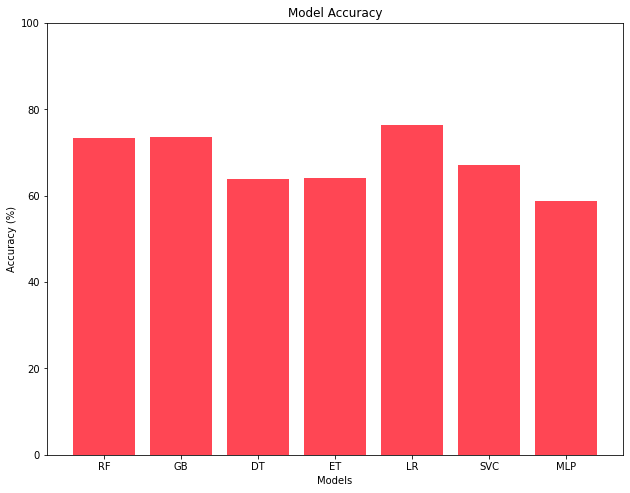

In [15]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
models = ['RF', 'GB', 'DT', 'ET', 'LR', 'SVC', 'MLP']
accuracies = [np.round(accuracy_rf*100,2), np.round(accuracy_gb*100,2), np.round(accuracy_dt*100,2), np.round(accuracy_et*100,2), np.round(accuracy_lr*100,2), np.round(accuracy_svc*100,2), np.round(accuracy_mlp*100,2)]
ax.bar(models,accuracies, color='#FF4654')
# Set y-axis to be 0-100
ax.set_ylim(0,100)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy')
ax.set_xlabel('Models')
plt.rcParams.update({'font.size': 18})
plt.show()

Text(0.5, 0, 'Feature Importance')

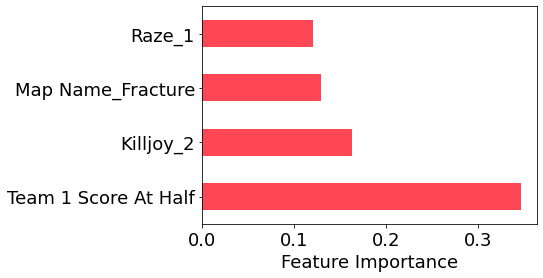

In [16]:

(pd.Series(lr.coef_[0], index=X.columns)
   .nlargest(4)
   .plot(kind='barh', color='#FF4654').set_xlabel('Feature Importance'))  